**SOLVING SOVEREIGN DEFAULT MODELS USING CUDA IN JULIA**

AUTHOR: Pablo A. Guerron-Quintana
Boston College
2021,
Mingzhuo Deng
University of Pennsylvania
2021

A Quick Introduction to Sovereign Defaul Models (taken from Guerron-Quintana et al. 2021 "Parallel Computation of Sovereign Default Models")

The model contains an open economy with a central government. The small open economy receives a stochastic endowment $y$ each period with law of motion:
    \[
    y' = \rho y + \sigma_y \epsilon, \quad \epsilon \sim N(0,1).
    \]
    Each period, the government chooses between repaying the debt obligations or defaulting payment to maximize utility of the households.
    The Value-of-Repayment is
    $$V_r(y,b) = \max_{b'\le0,c\ge0}U(c) + \beta \mathbf{E}V(y',b')$$ subject to the budget constraint $$c+q(y,b')b' \leq y+b,$$
    where $q(y,b')$ is the price of debt issued today, $b'$, given that the endowment is $y$. $\mathbf{E}$ is the expectation operator over future shocks.\\
    The value function if defaulting is given by
    $$ V_d(y) = U((1-\tau)y) + \mathbf{E}(\phi V(y',0) + (1-\phi)V_r(y')].$$
    Here $\tau$ is the fraction of the endowment lost because of default and $\phi$ is the exogenous probability to be readmitted to the financial markets next period. Note if readmitted, the sovereign economy starts with zero liabilities.
    The planner selects a default choice $d$ by solving the problem $V(y,b) = \max _{d\in\{0,1\}} (d V_d(y) + (1-d)V_r(y,b))$.

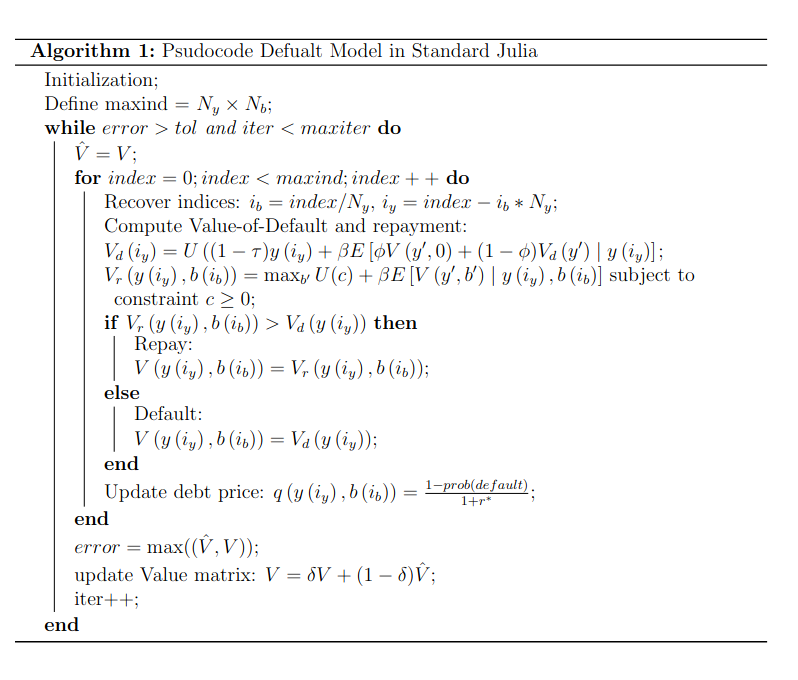

The code is tested using Julia 1.6.3. and CUDA 11 running on an AERO-Gygabyte laptop with Ubuntu 20 and NVIDIA RTX3080.

First, install some libraries.

In [1]:
using Pkg
Pkg.add("Random")
Pkg.add("Distributions")
Pkg.add("CUDA")
using Random, Distributions, CUDA, Base.Threads

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


This function discretizes the endowment process using Tauchen's method.

In [2]:
#tauchen method for creating conditional probability matrix
function tauchen(ρ, σ, Ny, P)
    #Create equally spaced pts to fill into Z
    σ_z = sqrt((σ^2)/(1-ρ^2))
    Step = 10*σ_z/(Ny-1)
    Z = -5*σ_z:Step:5*σ_z

    #Fill in entries of 1~ny, ny*(ny-1)~ny^2
    for z in 1:Ny
        P[z,1] = cdf(Normal(), (Z[1]-ρ*Z[z] + Step/2)/σ)
        P[z,Ny] = 1 - cdf(Normal(),(Z[Ny] - ρ*Z[z] - Step/2)/σ)
    end

    #Fill in the middle part
    for z in 1:Ny
        for iz in 2:(Ny-1)
            P[z,iz] = cdf(Normal(), (Z[iz]-ρ*Z[z]+Step/2)/σ) - cdf(Normal(), (Z[iz]-ρ*Z[z]-Step/2)/σ)
        end
    end
end

tauchen (generic function with 1 method)

In [8]:
#line 7.1 Intitializing U((1-τ)iy) to each Vd[iy]
function def_init(sumdef,τ,Y,α)
    iy = threadIdx().x
    stride = blockDim().x
    for i = iy:stride:length(sumdef)
        # If using Julia 1.5 or lower, uncomment next line
        # sumdef[i] = (CUDA.pow(CUDA.exp((1-τ)*Y[i]),(1-α)))/(1-α)
        # Comment the next one
        sumdef[i] = ((CUDA.exp((1-τ)*Y[i]))^(1-α))/(1-α)
    end
    return
end

def_init (generic function with 1 method)

In [4]:
#line 7.2 adding second expected part to calcualte Vd[iy]
function def_add(matrix, P, β, V0, Vd0, ϕ, Ny)
    y = (blockIdx().x-1)*blockDim().x + threadIdx().x
    iy = (blockIdx().y-1)*blockDim().y + threadIdx().y

    if (iy <= Ny && y <= Ny)
        matrix[iy,y] = β* P[iy,y]* (ϕ* V0[y,1] + (1-ϕ)* Vd0[y])
    end
    return
end

def_add (generic function with 1 method)

In [9]:
#line 8 Calculate Vr, still a double loop inside, tried to flatten out another loop
function vr(Nb,Ny,α,β,τ,Vr,V0,Y,B,Price0,P)

    ib = (blockIdx().x-1)*blockDim().x + threadIdx().x
    iy = (blockIdx().y-1)*blockDim().y + threadIdx().y

    if (ib <= Nb && iy <= Ny)

        Max = -Inf
        for b in 1:Nb
            c = CUDA.exp(Y[iy]) + B[ib] - Price0[iy,b]*B[b]
            if c > 0 #If consumption positive, calculate value of return
                sumret = 0
                for y in 1:Ny
                    sumret += V0[y,b]*P[iy,y]
                end
                # If running Julia 1.5 or lower, uncomment next line
                # vr = CUDA.pow(c,(1-α))/(1-α) + β * sumret
                # and comment the next one
                vr = (c^(1-α))/(1-α) + β * sumret
                Max = CUDA.max(Max, vr)
            end
        end
        Vr[iy,ib] = Max
    end
    return
end

vr (generic function with 1 method)

In [5]:
#line 9-14 debt price update
function Decide(Nb,Ny,Vd,Vr,V,decision,decision0,prob,P,Price,rstar)

    ib = (blockIdx().x-1)*blockDim().x + threadIdx().x
    iy = (blockIdx().y-1)*blockDim().y + threadIdx().y

    if (ib <= Nb && iy <= Ny)

        if (Vd[iy] < Vr[iy,ib])
            V[iy,ib] = Vr[iy,ib]
            decision[iy,ib] = 0
        else
            V[iy,ib] = Vd[iy]
            decision[iy,ib] = 1
        end

        for y in 1:Ny
            prob[iy,ib] += P[iy,y] * decision[y,ib]
        end

        Price[iy,ib] = (1-prob[iy,ib]) / (1+rstar)

    end
    return
end

Decide (generic function with 1 method)

The main function is next. Here, we parametrize the model, initialize variables and CUDA arrays, and solve the model using value function iteration.

In [10]:
function main()

    #Setting parameters
    #Modify Ny and Nb to change granularity of endowment and debt grids
    Ny = 200 #grid number of endowment
    Nb = 200 #grid number of bond
    maxInd = Ny * Nb #total grid points
    rstar = 0.017 #r* used in price calculation
    α = 0.5 #α used in utility function

    #lower bound and upper bound for bond initialization
    lbd = -1
    ubd = 0

    #β,ϕ,τ used as in part 4 of original paper
    β = 0.953
    ϕ = 0.282
    τ = 0.5

    δ = 0.8 #weighting average of new and old matrixs

    #ρ,σ For tauchen method
    ρ = 0.9
    σ = 0.025


    #Initializing Bond matrix
    minB = lbd
    maxB = ubd
    step = (maxB-minB) / (Nb-1)
    B = CuArray(minB:step:maxB) #Bond

    #Intitializing Endowment matrix
    σ_z = sqrt((σ^2)/(1-ρ^2))
    Step = 10*σ_z/(Ny-1)
    Y = CuArray(-5*σ_z:Step:5*σ_z) #Endowment

    Pcpu = zeros(Ny,Ny)  #Conditional probability matrix
    V = CUDA.fill(1/((1-β)*(1-α)),Ny, Nb) #Value
    Price = CUDA.fill(1/(1+rstar),Ny, Nb) #Debt price
    Vr = CUDA.zeros(Ny, Nb) #Value of good standing
    Vd = CUDA.zeros(Ny) #Value of default
    decision = CUDA.ones(Ny,Nb) #Decision matrix


    U(x) = x^(1-α) / (1-α) #Utility function

    #Initialize Conditional Probability matrix
    tauchen(ρ, σ, Ny, Pcpu)
    P = CuArray(Pcpu)

    err = 2000 #error
    tol = 1e-6 #error toleration
    iter = 0
    maxIter = 300 #Maximum interation

#------
#Based on Paper Part4, Sovereign meets C++

    #line 3
    while (err > tol) & (iter < maxIter)
        #Keeping copies of Value, Value of defualt, Price for the previous round
        V0 = CUDA.deepcopy(V)
        Vd0 = CUDA.deepcopy(Vd)
        Price0 = CUDA.deepcopy(Price)
        prob = CUDA.zeros(Ny,Nb)
        decision = CUDA.ones(Ny,Nb)
        decision0 = CUDA.deepcopy(decision)
        threadcount = (32,32) #set up defualt thread numbers per block

        #line 7, Value of Default computation
        sumdef = CUDA.zeros(Ny)
        @cuda threads=64 def_init(sumdef,τ,Y,α)

        temp = CUDA.zeros(Ny,Ny)

        blockcount = (ceil(Int,Ny/10),ceil(Int,Ny/10))
        @cuda threads=threadcount blocks=blockcount def_add(temp, P, β, V0, Vd0, ϕ, Ny)
        temp = sum(temp,dims=2)
        Vd = sumdef + temp

        #line 8, Value of Repayment computation

        blockcount = (ceil(Int,Nb/10),ceil(Int,Ny/10))
        @cuda threads=threadcount blocks=blockcount vr(Nb,Ny,α,β,τ,Vr,V0,Y,B,Price0,P)

        #line 9-14, Decision computation

        blockcount = (ceil(Int,Nb/10),ceil(Int,Ny/10))
        @cuda threads=threadcount blocks=blockcount Decide(Nb,Ny,Vd,Vr,V,decision,decision0,prob,P,Price,rstar)

        #line 16
        #update Error and value matrix at round end

        err = maximum(abs.(V-V0))
        PriceErr = maximum(abs.(Price-Price0))
        VdErr = maximum(abs.(Vd-Vd0))
        Vd = δ * Vd + (1-δ) * Vd0
        Price = δ * Price + (1-δ) * Price0
        V = δ * V + (1-δ) * V0

        iter += 1
        println("Errors of round $iter: Value error: $err, price error: $PriceErr, Vd error: $VdErr")

    end

    #Print final results
    println("Total Round ",iter)

    Vd = Vd[:,:]

    println("Vr: ====================")
    display(Vr)
    println("Vd: ==================")
    display(Vd)
    println("Decision: ==================")
    display(decision)
    println("Price: ==================")
    display(Price)

    return Vr,Vd,decision,Price

end

main (generic function with 1 method)

Compile and run the main function. Note that the first time will run slow due to compilation.

In [11]:
@time VReturn, VDefault, Decision, Price = main()

Errors of round 1: Value error: 1.0432898338805217, price error: 0.027002545115753063, Vd error: 13.58465
Errors of round 2: Value error: 0.40724347703000774, price error: 0.07930313005325496, Vd error: 10.200076675415039
Errors of round 3: Value error: 0.2848216507282615, price error: 0.06344250404260376, Vd error: 7.662964935302735
Errors of round 4: Value error: 0.22377341217690372, price error: 0.042724632818321506, Vd error: 5.7606489410400386
Errors of round 5: Value error: 0.1861922129529603, price error: 0.03417970625465705, Vd error: 4.3338943908691405
Errors of round 6: Value error: 0.16413369241917763, price error: 0.026993904301315985, Vd error: 3.2634120263671917
Errors of round 7: Value error: 0.1465383849682098, price error: 0.02679343740637663, Vd error: 2.4599028642578133
Errors of round 8: Value error: 0.12998017157372033, price error: 0.026960723573877687, Vd error: 1.8564443790039036
Errors of round 9: Value error: 0.12953022132646197, price error: 0.026995563337687

Errors of round 71: Value error: 0.011864839670941763, price error: 0.0560415861476255, Vd error: 0.007597838439536986
Errors of round 72: Value error: 0.011522900810120973, price error: 0.056041586147692, Vd error: 0.007401830871501147
Errors of round 73: Value error: 0.011206798587338085, price error: 0.05604121452094285, Vd error: 0.007210041467274664
Errors of round 74: Value error: 0.011077299340435331, price error: 0.05462326005117146, Vd error: 0.007011466301264591
Errors of round 75: Value error: 0.010750275413123234, price error: 0.05462199229593029, Vd error: 0.00680771928563928
Errors of round 76: Value error: 0.010530947744584296, price error: 0.05461275704963764, Vd error: 0.006610567294629277
Errors of round 77: Value error: 0.01029818178840003, price error: 0.05461268329128943, Vd error: 0.00640710491400398
Errors of round 78: Value error: 0.010027498846881144, price error: 0.054557470062953084, Vd error: 0.006194751060924375
Errors of round 79: Value error: 0.0095861349

Errors of round 142: Value error: 0.0010095144531447886, price error: 0.04519719993118698, Vd error: 0.0001916891967397305
Errors of round 143: Value error: 0.0008431212150128431, price error: 0.04519719993118698, Vd error: 0.0001871110327087422
Errors of round 144: Value error: 0.0008923951864758806, price error: 0.04519719993118698, Vd error: 0.0001747513081085117
Errors of round 145: Value error: 0.0008988461931522806, price error: 0.04519719993118698, Vd error: 0.00016083527138732734
Errors of round 146: Value error: 0.0008686127406392075, price error: 0.04519719993118698, Vd error: 0.00013897857770928113
Errors of round 147: Value error: 0.0007437077147898208, price error: 0.04519719993118698, Vd error: 0.00013079254171088905
Errors of round 148: Value error: 0.000470873632735902, price error: 0.04519719993118698, Vd error: 0.00012152593998138173
Errors of round 149: Value error: 0.0008122216536676774, price error: 0.04519719993118698, Vd error: 0.00011585792236701309
Errors of ro

Errors of round 209: Value error: 1.2251535743246222e-5, price error: 1.1823875212257917e-14, Vd error: 1.2251535743246222e-5
Errors of round 210: Value error: 1.240289512338677e-5, price error: 0.04517920718197743, Vd error: 1.240289512338677e-5
Errors of round 211: Value error: 0.0002365124629903903, price error: 0.00903584143639552, Vd error: 1.2397815396525402e-5
Errors of round 212: Value error: 4.73024926037624e-5, price error: 0.001807168287279115, Vd error: 9.219066903654038e-6
Errors of round 213: Value error: 1.1758119711657855e-5, price error: 0.0003614336574558341, Vd error: 1.1758119711657855e-5
Errors of round 214: Value error: 8.584283385459912e-6, price error: 7.228673149117792e-5, Vd error: 8.584283385459912e-6
Errors of round 215: Value error: 8.577992687719416e-6, price error: 1.4457346298235585e-5, Vd error: 8.577992687719416e-6
Errors of round 216: Value error: 1.1761977447122263e-5, price error: 2.891469259691526e-6, Vd error: 1.1761977447122263e-5
Errors of round

Errors of round 276: Value error: 4.577343752032448e-6, price error: 2.295280232544883e-8, Vd error: 3.814697265625e-6
Errors of round 277: Value error: 7.62939453125e-6, price error: 4.590560487294226e-9, Vd error: 7.62939453125e-6
Errors of round 278: Value error: 3.973386327515982e-6, price error: 9.181121418677662e-10, Vd error: 7.6292969026781066e-6
Errors of round 279: Value error: 4.577636723013256e-6, price error: 1.8362245057801374e-10, Vd error: 4.577636723013256e-6
Errors of round 280: Value error: 7.62939453125e-6, price error: 3.672451232006324e-11, Vd error: 7.62939453125e-6
Errors of round 281: Value error: 3.967285159944822e-6, price error: 7.344902464012648e-12, Vd error: 3.967285159944822e-6
Errors of round 282: Value error: 3.820851546265658e-6, price error: 1.4689360838815446e-12, Vd error: 3.814697343784701e-6
Errors of round 283: Value error: 3.845214848752221e-6, price error: 2.937650123158164e-13, Vd error: 3.845214848752221e-6
Errors of round 284: Value error: 

200×200 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 -Inf      -Inf      -Inf      …  41.4319  41.4377  41.4435  41.4493
 -Inf      -Inf      -Inf         41.4416  41.4474  41.4532  41.459
 -Inf      -Inf      -Inf         41.4515  41.4573  41.4631  41.4689
 -Inf      -Inf      -Inf         41.4615  41.4673  41.4731  41.4789
 -Inf      -Inf      -Inf         41.4717  41.4775  41.4833  41.4891
 -Inf      -Inf      -Inf      …  41.482   41.4878  41.4936  41.4994
 -Inf      -Inf      -Inf         41.4924  41.4982  41.504   41.5097
 -Inf      -Inf      -Inf         41.5029  41.5087  41.5145  41.5202
 -Inf      -Inf      -Inf         41.5135  41.5193  41.525   41.5308
 -Inf      -Inf      -Inf         41.5241  41.5299  41.5357  41.5414
 -Inf      -Inf      -Inf      …  41.5348  41.5406  41.5463  41.5521
 -Inf      -Inf      -Inf         41.5456  41.5514  41.5571  41.5628
 -Inf      -Inf      -Inf         41.5564  41.5621  41.5679  41.5736
   ⋮                           ⋱                    

Vr: ====================


200×1 CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}:
 41.5781364428711
 41.586666107167964
 41.59536740112305
 41.60422515868906
 41.61322021362297
 41.62233352655273
 41.631549834960936
 41.640853875730464
 41.65023040649414
 41.65967559814453
 41.669178009029295
 41.6787300109375
 41.688312530507815
  ⋮
 43.50013732910156
 43.51362609863281
 43.52724075317383
 43.54097366333008
 43.55480194091797
 43.568687438964844
 43.58261108276367
 43.5965232849121
 43.61038589477539
 43.624176025390625
 43.63783645629881
 43.65132522583008

Vd: ==================


200×200 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1

200×200 CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}:
  5.86083e-8     5.86083e-8     5.86083e-8    …   5.86083e-8     5.86083e-8
  1.71779e-199   1.84364e-199   1.95722e-199      1.21487e-179   4.5767e-179
  5.86083e-8     5.86083e-8     5.86083e-8        5.86083e-8     5.86083e-8
 -1.17217e-7    -1.17217e-7    -1.17217e-7       -1.17217e-7    -1.17217e-7
  1.17217e-7     1.17217e-7     1.17217e-7        1.17217e-7     1.17217e-7
  2.20325e-199   2.35625e-199   2.46815e-199  …   3.38539e-178   1.58575e-177
  1.17217e-7     1.17217e-7     1.17217e-7        1.17217e-7     1.17217e-7
  2.34433e-7     2.34433e-7     2.34433e-7        2.34433e-7     2.34433e-7
  2.34433e-7     2.34433e-7     2.34433e-7        2.34433e-7     2.34433e-7
  2.63853e-199   2.84481e-199   2.97876e-199      6.88024e-175   3.43946e-174
  5.86083e-8     5.86083e-8     5.86083e-8    …   5.86083e-8     5.86083e-8
  2.89311e-199   3.14733e-199   3.30861e-199      6.88422e-173   3.4421e-172
  5.86083e-8     5.86083e-8   

Decision: ==================
Price: ==================
 20.672305 seconds (42.36 M allocations: 1.727 GiB, 1.19% gc time, 4.12% compilation time)


(Float32[-Inf -Inf … 41.443535 41.44934; -Inf -Inf … 41.453228 41.45903; … ; 43.869236 43.87397 … 44.726234 44.730335; 43.890858 43.895546 … 44.745815 44.749916], [41.5781364428711; 41.586666107167964; … ; 43.63783645629881; 43.65132522583008], Float32[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [5.860830361395343e-8 5.860830361395343e-8 … 5.860830361395343e-8 5.860830361395343e-8; 1.7177912822573472e-199 1.8436436614632608e-199 … 1.2148745156534736e-179 4.576697113904397e-179; … ; 0.8753537545630832 0.8951563867964694 … 0.9832841691248773 0.9832841691248773; 0.893307001775931 0.9105467515005827 … 0.9832841691248773 0.9832841691248773])

In [13]:
# Run one more time to get actual solution time. It took 7 seconds to solve model in a grid of 200 x 200. Not bad!
@time main()

Errors of round 1: Value error: 1.0432898338805217, price error: 0.027002545115753063, Vd error: 13.58465
Errors of round 2: Value error: 0.40724347703000774, price error: 0.021602036092602472, Vd error: 10.200076675415039
Errors of round 3: Value error: 0.2848216507282615, price error: 0.025922443311122922, Vd error: 7.662964935302735
Errors of round 4: Value error: 0.22377341217690372, price error: 0.11445135024679343, Vd error: 5.7606489410400386
Errors of round 5: Value error: 0.1861922129529603, price error: 0.09156108019743459, Vd error: 4.3338943908691405
Errors of round 6: Value error: 0.1757916123410439, price error: 0.11445135024679343, Vd error: 3.2634120263671917
Errors of round 7: Value error: 0.14804284395258094, price error: 0.09156108019743459, Vd error: 2.4599028642578133
Errors of round 8: Value error: 0.13268600756004645, price error: 0.02592278894370048, Vd error: 1.8564443790039036
Errors of round 9: Value error: 0.12422386829911858, price error: 0.1143048525184774

Errors of round 71: Value error: 0.011864839670941763, price error: 0.0560415861476255, Vd error: 0.007597838439536986
Errors of round 72: Value error: 0.011522900810120973, price error: 0.056041586147692, Vd error: 0.007401830871501147
Errors of round 73: Value error: 0.011206798587338085, price error: 0.05604121452094285, Vd error: 0.007210041467274664
Errors of round 74: Value error: 0.011077299340435331, price error: 0.05462326005117146, Vd error: 0.007011466301264591
Errors of round 75: Value error: 0.010750275413123234, price error: 0.05462199229593029, Vd error: 0.00680771928563928
Errors of round 76: Value error: 0.010530947744584296, price error: 0.05461275704963764, Vd error: 0.006610567294629277
Errors of round 77: Value error: 0.01029818178840003, price error: 0.05461268329128943, Vd error: 0.00640710491400398
Errors of round 78: Value error: 0.010027498846881144, price error: 0.054557470062953084, Vd error: 0.006194751060924375
Errors of round 79: Value error: 0.0095861349

Errors of round 141: Value error: 0.0009726345140279591, price error: 0.04519719993118709, Vd error: 0.00019550653058786338
Errors of round 142: Value error: 0.0010095144531447886, price error: 0.04519719993118698, Vd error: 0.0001916891967397305
Errors of round 143: Value error: 0.0008431212150128431, price error: 0.04519719993118698, Vd error: 0.0001871110327087422
Errors of round 144: Value error: 0.0008923951864758806, price error: 0.04519719993118698, Vd error: 0.0001747513081085117
Errors of round 145: Value error: 0.0008988461931522806, price error: 0.04519719993118698, Vd error: 0.00016083527138732734
Errors of round 146: Value error: 0.0008686127406392075, price error: 0.04519719993118698, Vd error: 0.00013897857770928113
Errors of round 147: Value error: 0.0007437077147898208, price error: 0.04519719993118698, Vd error: 0.00013079254171088905
Errors of round 148: Value error: 0.000470873632735902, price error: 0.04519719993118698, Vd error: 0.00012152593998138173
Errors of ro

Errors of round 211: Value error: 0.0002365124629903903, price error: 0.00903584143639552, Vd error: 1.2397815396525402e-5
Errors of round 212: Value error: 4.73024926037624e-5, price error: 0.001807168287279115, Vd error: 9.219066903654038e-6
Errors of round 213: Value error: 1.1758119711657855e-5, price error: 0.0003614336574558341, Vd error: 1.1758119711657855e-5
Errors of round 214: Value error: 8.584283385459912e-6, price error: 7.228673149117792e-5, Vd error: 8.584283385459912e-6
Errors of round 215: Value error: 8.577992687719416e-6, price error: 1.4457346298235585e-5, Vd error: 8.577992687719416e-6
Errors of round 216: Value error: 1.1761977447122263e-5, price error: 2.891469259691526e-6, Vd error: 1.1761977447122263e-5
Errors of round 217: Value error: 1.1634836113216807e-5, price error: 5.782938519716119e-7, Vd error: 1.1634836113216807e-5
Errors of round 218: Value error: 9.167980977053958e-6, price error: 1.1565877044983353e-7, Vd error: 9.167980977053958e-6
Errors of round

Errors of round 280: Value error: 7.62939453125e-6, price error: 3.672451232006324e-11, Vd error: 7.62939453125e-6
Errors of round 281: Value error: 3.967285159944822e-6, price error: 7.344902464012648e-12, Vd error: 3.967285159944822e-6
Errors of round 282: Value error: 3.820851546265658e-6, price error: 1.4689360838815446e-12, Vd error: 3.814697343784701e-6
Errors of round 283: Value error: 3.845214848752221e-6, price error: 2.937650123158164e-13, Vd error: 3.845214848752221e-6
Errors of round 284: Value error: 3.820800777987188e-6, price error: 5.873079800267078e-14, Vd error: 3.820800777987188e-6
Errors of round 285: Value error: 3.8149434402612314e-6, price error: 1.176836406102666e-14, Vd error: 3.814941408109007e-6
Errors of round 286: Value error: 7.62939453125e-6, price error: 2.3314683517128287e-15, Vd error: 7.62939453125e-6
Errors of round 287: Value error: 4.577636723013256e-6, price error: 5.551115123125783e-16, Vd error: 4.577636723013256e-6
Errors of round 288: Value er

200×200 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 -Inf      -Inf      -Inf      …  41.4319  41.4377  41.4435  41.4493
 -Inf      -Inf      -Inf         41.4416  41.4474  41.4532  41.459
 -Inf      -Inf      -Inf         41.4515  41.4573  41.4631  41.4689
 -Inf      -Inf      -Inf         41.4615  41.4673  41.4731  41.4789
 -Inf      -Inf      -Inf         41.4717  41.4775  41.4833  41.4891
 -Inf      -Inf      -Inf      …  41.482   41.4878  41.4936  41.4994
 -Inf      -Inf      -Inf         41.4924  41.4982  41.504   41.5097
 -Inf      -Inf      -Inf         41.5029  41.5087  41.5145  41.5202
 -Inf      -Inf      -Inf         41.5135  41.5193  41.525   41.5308
 -Inf      -Inf      -Inf         41.5241  41.5299  41.5357  41.5414
 -Inf      -Inf      -Inf      …  41.5348  41.5406  41.5463  41.5521
 -Inf      -Inf      -Inf         41.5456  41.5514  41.5571  41.5628
 -Inf      -Inf      -Inf         41.5564  41.5621  41.5679  41.5736
   ⋮                           ⋱                    

200×1 CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}:
 41.5781364428711
 41.586666107167964
 41.59536740112305
 41.60422515868906
 41.61322021362297
 41.62233352655273
 41.631549834960936
 41.640853875730464
 41.65023040649414
 41.65967559814453
 41.669178009029295
 41.6787300109375
 41.688312530507815
  ⋮
 43.50013732910156
 43.51362609863281
 43.52724075317383
 43.54097366333008
 43.55480194091797
 43.568687438964844
 43.58261108276367
 43.5965232849121
 43.61038589477539
 43.624176025390625
 43.63783645629881
 43.65132522583008

200×200 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1

200×200 CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}:
  5.86083e-8     5.86083e-8     5.86083e-8    …   5.86083e-8     5.86083e-8
  1.66234e-199   1.78819e-199   2.01414e-199      1.21487e-179   4.5767e-179
  5.86083e-8     5.86083e-8     5.86083e-8        5.86083e-8     5.86083e-8
 -1.17217e-7    -1.17217e-7    -1.17217e-7       -1.17217e-7    -1.17217e-7
  1.17217e-7     1.17217e-7     1.17217e-7        1.17217e-7     1.17217e-7
  2.0994e-199    2.2524e-199    2.46815e-199  …   3.38539e-178   1.58575e-177
  1.17217e-7     1.17217e-7     1.17217e-7        1.17217e-7     1.17217e-7
  2.34433e-7     2.34433e-7     2.34433e-7        2.34433e-7     2.34433e-7
  2.34433e-7     2.34433e-7     2.34433e-7        2.34433e-7     2.34433e-7
  2.55728e-199   2.76357e-199   2.97833e-199      6.88024e-175   3.43946e-174
  5.86083e-8     5.86083e-8     5.86083e-8    …   5.86083e-8     5.86083e-8
  2.82e-199      3.07421e-199   3.30232e-199      6.88422e-173   3.4421e-172
  5.86083e-8     5.86083e-8   

Errors of round 298: Value error: 3.814697272730427e-6, price error: 1.1102230246251565e-16, Vd error: 3.814697272730427e-6
Errors of round 299: Value error: 3.814697272730427e-6, price error: 1.1102230246251565e-16, Vd error: 7.629394573882564e-7
Errors of round 300: Value error: 3.814697272730427e-6, price error: 1.1102230246251565e-16, Vd error: 3.814697272730427e-6
Total Round 300
Vr: ====================
Vd: ==================
Decision: ==================
Price: ==================
  6.949860 seconds (26.67 M allocations: 824.717 MiB, 0.99% gc time)


(Float32[-Inf -Inf … 41.443535 41.44934; -Inf -Inf … 41.453228 41.45903; … ; 43.869236 43.87397 … 44.726234 44.730335; 43.890858 43.895546 … 44.745815 44.749916], [41.5781364428711; 41.586666107167964; … ; 43.63783645629881; 43.65132522583008], Float32[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [5.860830361395343e-8 5.860830361395343e-8 … 5.860830361395343e-8 5.860830361395343e-8; 1.6623373745496972e-199 1.7881897537556078e-199 … 1.2148745156534736e-179 4.576697113904397e-179; … ; 0.8753537545630832 0.8951563867964694 … 0.9832841691248773 0.9832841691248773; 0.893307001775931 0.9105467515005827 … 0.9832841691248773 0.9832841691248773])